<a href="https://colab.research.google.com/github/DL4CV-NPTEL/Deep-Learning-For-Computer-Vision/blob/main/notebooks/Week_4/Week_4_Lecture_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 4: Feedforward Neural Networks and Backpropagation Part 2 <sup><mark style="background-color:gold">Code</mark> </sup>

In [20]:
#@title 
from ipywidgets import widgets
out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"XV20CvRsIJU", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)
display(out1)

Output()

In [21]:
#@title 
from IPython import display as IPyDisplay
IPyDisplay.HTML(
    f"""
  <div>
    <a href= "https://github.com/DL4CV-NPTEL/Deep-Learning-For-Computer-Vision/blob/main/Slides/Week_4/DL4CV_Week04_Part02.pdf" target="_blank">
    <img src="https://github.com/DL4CV-NPTEL/Deep-Learning-For-Computer-Vision/blob/main/Data/Slides_Logo.png?raw=1"
  alt="button link to Airtable" style="width:200px"></a>
    </div>""" )

**Imports**

In [22]:
import torch
import numpy as np
from torch import nn
from math import pi
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random

**Helper Function for Plotting**

In [23]:
def ex3_plot(model, x, y, ep, lss):
  """
  Plot training loss

  Args:
    model: nn.module
      Model implementing regression
    x: np.ndarray
      Training Data
    y: np.ndarray
      Targets
    ep: int
      Number of epochs
    lss: function
      Loss function

  Returns:
    Nothing
  """
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
  ax1.set_title("Regression")
  ax1.plot(x, model(x).detach().numpy(), color='r', label='prediction')
  ax1.scatter(x, y, c='c', label='targets')
  ax1.set_xlabel('x')
  ax1.set_ylabel('y')
  ax1.legend()

  ax2.set_title("Training loss")
  ax2.plot(np.linspace(1, epochs, epochs), losses, color='y')
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("MSE")

  plt.show()


**Helper Function for random seed**

In [24]:
def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

**Helper Function for Device**

In [25]:
def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [26]:
SEED = 2022
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2022 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


## PyTorch's Neural Net module (`nn.Module`)

PyTorch provides us with ready-to-use neural network building blocks, such as layers (e.g., linear, recurrent, etc.), different activation and loss functions, and much more, packed in the [`torch.nn`](https://pytorch.org/docs/stable/nn.html) module. If we build a neural network using `torch.nn` layers, the weights and biases are already in `requires_grad` mode and will be registered as model parameters. 

For training, we need three things:

* **Model parameters:** Model parameters refer to all the learnable parameters of the model, which are accessible by calling `.parameters()` on the model. Please note that NOT all the `requires_grad` tensors are seen as model parameters. To create a custom model parameter, we can use [`nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html) (*A kind of Tensor that is to be considered a module parameter*).

* **Loss function:** The loss that we are going to be optimizing, which is often combined with regularization terms (coming up in few days).

* **Optimizer:** PyTorch provides us with many optimization methods (different versions of gradient descent). Optimizer holds the current state of the model and by calling the `step()` method, will update the parameters based on the computed gradients.

You will learn more details about choosing the right model architecture, loss function, and optimizer later in the course.

### Training loop in PyTorch

We use a regression problem to study the training loop in PyTorch.

The task is to train a wide nonlinear (using $\tanh$ activation function) neural net for a simple $\sin$ regression task. Wide neural networks are thought to be really good at generalization.

**Generate Sample Data**

Random seed 2022 has been set.


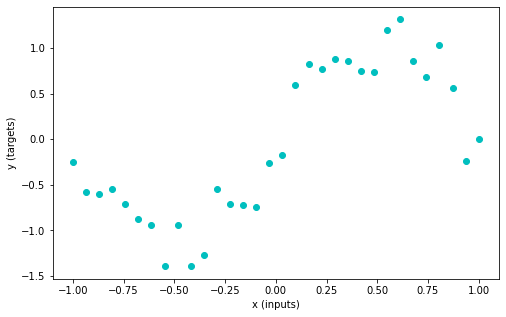

In [27]:
set_seed(seed=SEED)
n_samples = 32
inputs = torch.linspace(-1.0, 1.0, n_samples).reshape(n_samples, 1)
noise = torch.randn(n_samples, 1) / 4
targets = torch.sin(pi * inputs) + noise
plt.figure(figsize=(8, 5))
plt.scatter(inputs, targets, c='c')
plt.xlabel('x (inputs)')
plt.ylabel('y (targets)')
plt.show()

Let's define a very wide (512 neurons) neural net with one hidden layer and `nn.Tanh()` activation function.

In [28]:
class WideNet(nn.Module):
  """
   A Wide neural network with a single hidden layer
   Structure is as follows:
   nn.Sequential(
        nn.Linear(1, n_cells) + nn.Tanh(), # Fully connected layer with tanh activation
        nn.Linear(n_cells, 1) # Final fully connected layer
    )
  """

  def __init__(self):
    """
    Initializing the parameters of WideNet

    Args:
      None

    Returns:
      Nothing
    """
    n_cells = 512
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(1, n_cells),
        nn.Tanh(),
        nn.Linear(n_cells, 1),
    )

  def forward(self, x):
    """
    Forward pass of WideNet

    Args:
      x: torch.Tensor
        2D tensor of features

    Returns:
      Torch tensor of model predictions
    """
    return self.layers(x)

We can now create an instance of our neural net and print its parameters.

In [29]:
# Creating an instance
set_seed(seed=SEED)
wide_net = WideNet()
print(wide_net)

Random seed 2022 has been set.
WideNet(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [30]:
# Create a mse loss function
loss_function = nn.MSELoss()

# Stochstic Gradient Descent optimizer (you will learn about momentum soon)
lr = 0.003  # Learning rate
sgd_optimizer = torch.optim.SGD(wide_net.parameters(), lr=lr, momentum=0.9)

The training process in PyTorch is interactive - you can perform training iterations as you wish and inspect the results after each iteration. 

Let's perform one training iteration. You can run the cell multiple times and see how the parameters are being updated and the loss is reducing. This code block is the core of everything to come: please make sure you go line-by-line through all the commands and discuss their purpose with your pod.

In [31]:
# Reset all gradients to zero
sgd_optimizer.zero_grad()

# Forward pass (Compute the output of the model on the features (inputs))
prediction = wide_net(inputs)

# Compute the loss
loss = loss_function(prediction, targets)
print(f'Loss: {loss.item()}')

# Perform backpropagation to build the graph and compute the gradients
loss.backward()

# Optimizer takes a tiny step in the steepest direction (negative of gradient)
# and "updates" the weights and biases of the network
sgd_optimizer.step()

Loss: 0.675656795501709


#### Training Loop

Using everything we've learned so far, we ask you to complete the `train` function below.

Random seed 2022 has been set.


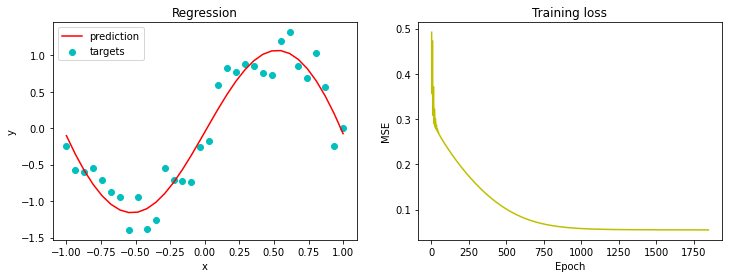

In [32]:
def train(features, labels, model, loss_fun, optimizer, n_epochs):
  """
  Training function

  Args:
    features: torch.Tensor
      Features (input) with shape torch.Size([n_samples, 1])
    labels: torch.Tensor
      Labels (targets) with shape torch.Size([n_samples, 1])
    model: torch nn.Module
      The neural network
    loss_fun: function
      Loss function
    optimizer: function
      Optimizer
    n_epochs: int
      Number of training iterations

  Returns:
    loss_record: list
      Record (evolution) of training losses
  """
  loss_record = []  # Keeping recods of loss

  for i in range(n_epochs):
    
    optimizer.zero_grad()  # Set gradients to 0
    predictions = model(features)   # Compute model prediction (output)
    loss = loss_fun(predictions, labels)  # Compute the loss
    loss.backward()  # Compute gradients (backward pass)
    optimizer.step()  # Update parameters (optimizer takes a step)


    loss_record.append(loss.item())
  return loss_record



set_seed(seed=2022)
epochs = 1847 # Cauchy, Exercices d'analyse et de physique mathematique (1847)
losses = train(inputs, targets, wide_net, loss_function, sgd_optimizer, epochs)
ex3_plot(wide_net, inputs, targets, epochs, losses)

**Acknowledgements**

Code adopted from the Deep Learning Summer School offered by Neuromatch Academy

https://deeplearning.neuromatch.io/tutorials/intro.html